## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.metrics import R2Score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-16 10:25:36.374967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:00:06.6310000Z', 'time_close': '2023-09-16T14:26:17.6690000Z', 'price_open': 26609, 'price_high': 26767, 'price_low': 26459, 'price_close': 26555, 'volume_traded': 445.7883835, 'trades_count': 4873}, {'time_period_start': '2023-09-15T00:00:00.0000000Z', 'time_period_end': '2023-09-16T00:00:00.0000000Z', 'time_open': '2023-09-15T00:00:32.9490000Z', 'time_close': '2023-09-15T23:59:45.8940000Z', 'price_open': 26529, 'price_high': 26878, 'price_low': 26228, 'price_close': 26607, 'volume_traded': 1379.10563562, 'trades_count': 11902}, {'time_period_start': '2023-09-14T00:00:00.0000000Z', 'time_period_end': '2023-09-15T00:00:00.0000000Z', 'time_open': '2023-09-14T00:00:15.5360000Z', 'time_close': '2023-09-14T23:59:56.7440000Z', 'price_open': 26229, 'price_high': 26849, 'price_low': 26143, 'price_close': 26529, 'volume_traded': 2067.19517712, 'trades_count': 14

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:06.6310000Z,2023-09-16T14:26:17.6690000Z,26609.0,26767.0,26459.0,26555.0,445.788384,4873
1,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:32.9490000Z,2023-09-15T23:59:45.8940000Z,26529.0,26878.0,26228.0,26607.0,1379.105636,11902
2,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:15.5360000Z,2023-09-14T23:59:56.7440000Z,26229.0,26849.0,26143.0,26529.0,2067.195177,14687
3,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:00:26.7790000Z,2023-09-13T23:59:42.8740000Z,25842.0,26395.0,25762.0,26226.0,1562.755225,12274
4,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:00:20.4450000Z,2023-09-12T23:59:52.9300000Z,25157.0,26529.0,25129.0,25844.0,3093.365986,18119


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


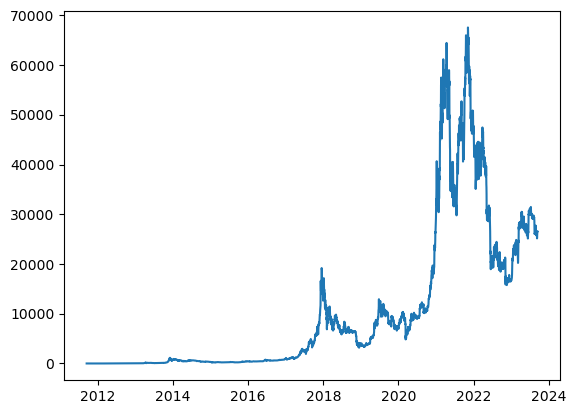

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4227, 7), (4227,), (4227,))

In [8]:
# non_positive_indices = np.where(shifted_df_as_np <= 0)
# print(non_positive_indices)


In [9]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3381, 7), (3381,), (423, 7), (423,), (423, 7), (423,))

In [10]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-16 10:27:42.604258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 4s 12ms/step - loss: 10.1282 - mean_absolute_error: 2.0198 - val_loss: 0.2279 - val_mean_absolute_error: 0.4527
Epoch 2/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0643 - val_loss: 0.0275 - val_mean_absolute_error: 0.1462
Epoch 3/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0532 - val_loss: 0.0088 - val_mean_absolute_error: 0.0762
Epoch 4/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0468 - val_loss: 0.0090 - val_mean_absolute_error: 0.0801
Epoch 5/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0464 - val_loss: 0.0041 - val_mean_absolute_error: 0.0510
Epoch 6/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0468 - val_loss: 0.0073 - val_mean_absolute_error: 0.0684
Epoch 7/

106/106 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0406 - val_loss: 0.0019 - val_mean_absolute_error: 0.0345
Epoch 51/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0389 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316
Epoch 52/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0377 - val_loss: 0.0022 - val_mean_absolute_error: 0.0374
Epoch 53/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0422 - val_loss: 0.0017 - val_mean_absolute_error: 0.0306
Epoch 54/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312
Epoch 55/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0424 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318
Epoch 56/100
106/

106/106 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0381 - val_loss: 0.0026 - val_mean_absolute_error: 0.0401
Epoch 100/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0436 - val_loss: 0.0080 - val_mean_absolute_error: 0.0823


106/106 [==============================] - 1s 3ms/step


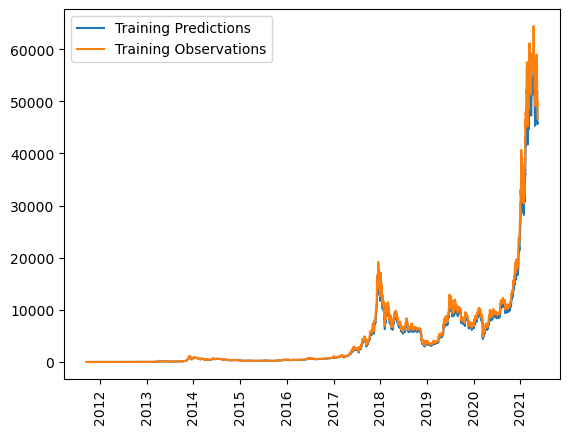

In [11]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [12]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.007996036671102047
Val MAE: 0.08225150406360626


14/14 [==============================] - 0s 4ms/step


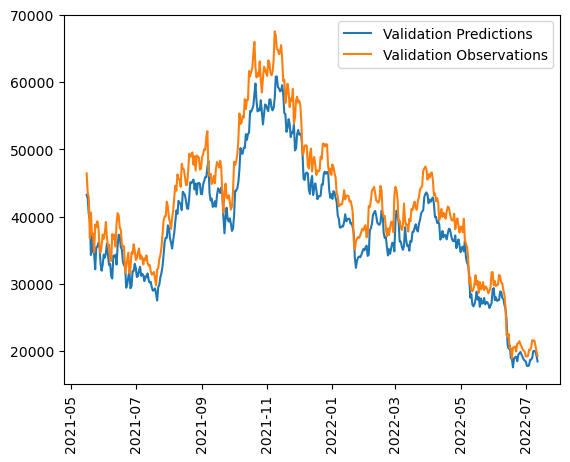

In [13]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [14]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.006811122409999371
Test MAE: 0.0790264755487442


14/14 [==============================] - 0s 3ms/step


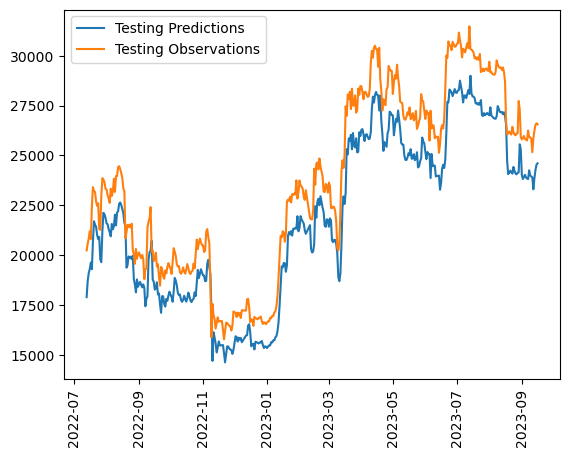

In [15]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [16]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.8193242920542059


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [17]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [18]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1649,),
 (1649, 7),
 (1649,),
 (253,),
 (253, 7),
 (253,),
 (212,),
 (212, 7),
 (212,))

In [19]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
52/52 [==============================] - 3s 17ms/step - loss: 85.1028 - mean_absolute_error: 9.1816 - val_loss: 83.6882 - val_mean_absolute_error: 9.1470
Epoch 2/200
52/52 [==============================] - 0s 7ms/step - loss: 71.8076 - mean_absolute_error: 8.4261 - val_loss: 70.4595 - val_mean_absolute_error: 8.3928
Epoch 3/200
52/52 [==============================] - 0s 7ms/step - loss: 56.5310 - mean_absolute_error: 7.4601 - val_loss: 50.9785 - val_mean_absolute_error: 7.1385
Epoch 4/200
52/52 [==============================] - 0s 8ms/step - loss: 35.8100 - mean_absolute_error: 5.9003 - val_loss: 27.9491 - val_mean_absolute_error: 5.2848
Epoch 5/200
52/52 [==============================] - 0s 8ms/step - loss: 16.2512 - mean_absolute_error: 3.8971 - val_loss: 10.2862 - val_mean_absolute_error: 3.2040
Epoch 6/200
52/52 [==============================] - 0s 8ms/step - loss: 4.7567 - mean_absolute_error: 1.9457 - val_loss: 2.2972 - val_mean_absolute_error: 1.5089
Epoch 7/200

Epoch 51/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0531 - val_loss: 0.0063 - val_mean_absolute_error: 0.0633
Epoch 52/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0043 - val_mean_absolute_error: 0.0470
Epoch 53/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0077 - val_mean_absolute_error: 0.0728
Epoch 54/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0039 - val_mean_absolute_error: 0.0437
Epoch 55/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0051 - val_mean_absolute_error: 0.0540
Epoch 56/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0534 - val_loss: 0.0071 - val_mean_absolute_error: 0.0686
Epoch 57/200
52/

Epoch 101/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0512 - val_loss: 0.0042 - val_mean_absolute_error: 0.0476
Epoch 102/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0507 - val_loss: 0.0038 - val_mean_absolute_error: 0.0441
Epoch 103/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0498 - val_loss: 0.0042 - val_mean_absolute_error: 0.0477
Epoch 104/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0029 - val_mean_absolute_error: 0.0355
Epoch 105/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0028 - val_mean_absolute_error: 0.0350
Epoch 106/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 0.0047 - val_mean_absolute_error: 0.0520
Epoch 107/

52/52 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0475 - val_loss: 0.0050 - val_mean_absolute_error: 0.0559
Epoch 151/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0034 - val_mean_absolute_error: 0.0421
Epoch 152/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0470 - val_loss: 0.0028 - val_mean_absolute_error: 0.0357
Epoch 153/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0454 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457
Epoch 154/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0026 - val_mean_absolute_error: 0.0341
Epoch 155/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0031 - val_mean_absolute_error: 0.0389
Epoch 156/200
52/52 [===

Epoch 200/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0452 - val_loss: 0.0024 - val_mean_absolute_error: 0.0323


52/52 [==============================] - 0s 3ms/step


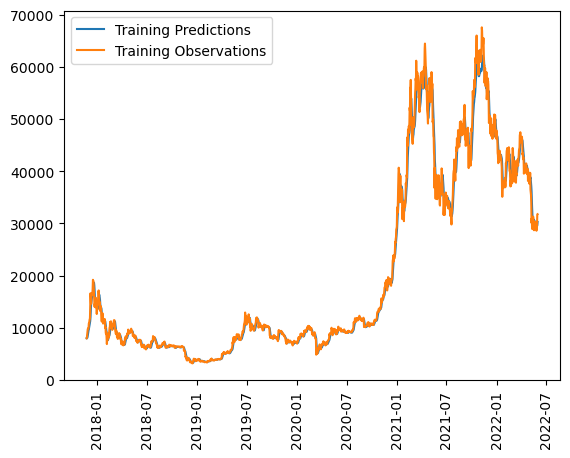

In [21]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [22]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00235475180670619
Val MAE: 0.03229518607258797


8/8 [==============================] - 0s 4ms/step


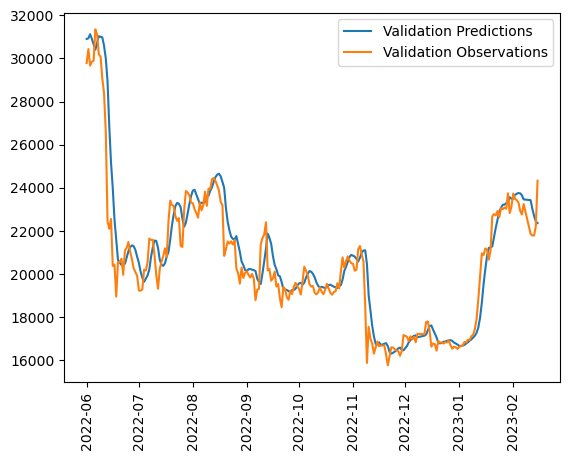

In [23]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [24]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0012332350015640259
Test MAE: 0.027375195175409317


In [25]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 4ms/step
R2 Score:  0.8385090160181683


7/7 [==============================] - 0s 3ms/step


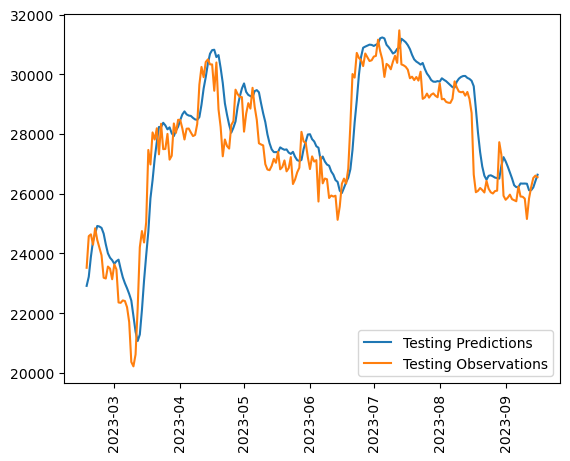

In [26]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [54]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
52/52 [==============================] - 3s 19ms/step - loss: 36.6041 - mean_absolute_error: 5.1549 - val_loss: 0.7810 - val_mean_absolute_error: 0.8718
Epoch 2/200
52/52 [==============================] - 0s 8ms/step - loss: 0.9420 - mean_absolute_error: 0.8006 - val_loss: 0.1366 - val_mean_absolute_error: 0.3419
Epoch 3/200
52/52 [==============================] - 0s 8ms/step - loss: 0.7025 - mean_absolute_error: 0.7304 - val_loss: 0.1774 - val_mean_absolute_error: 0.3986
Epoch 4/200
52/52 [==============================] - 0s 9ms/step - loss: 0.6383 - mean_absolute_error: 0.6973 - val_loss: 0.0544 - val_mean_absolute_error: 0.1966
Epoch 5/200
52/52 [==============================] - 0s 8ms/step - loss: 0.4678 - mean_absolute_error: 0.5923 - val_loss: 0.0314 - val_mean_absolute_error: 0.1514
Epoch 6/200
52/52 [==============================] - 0s 9ms/step - loss: 0.1131 - mean_absolute_error: 0.2641 - val_loss: 0.0031 - val_mean_absolute_error: 0.0395
Epoch 7/200
52/52 [=

Epoch 51/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0534 - val_loss: 0.0029 - val_mean_absolute_error: 0.0393
Epoch 52/200
52/52 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0581 - val_loss: 0.0071 - val_mean_absolute_error: 0.0751
Epoch 53/200
52/52 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0592 - val_loss: 0.0050 - val_mean_absolute_error: 0.0549
Epoch 54/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 55/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0049 - val_mean_absolute_error: 0.0594
Epoch 56/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0026 - val_mean_absolute_error: 0.0335
Epoch 57/200
52

Epoch 101/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0448 - val_loss: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 102/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0028 - val_mean_absolute_error: 0.0430
Epoch 103/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0426 - val_loss: 0.0023 - val_mean_absolute_error: 0.0363
Epoch 104/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0039 - val_mean_absolute_error: 0.0494
Epoch 105/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0459 - val_loss: 0.0032 - val_mean_absolute_error: 0.0472
Epoch 106/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0431 - val_loss: 0.0024 - val_mean_absolute_error: 0.0354
Epoch 107/

52/52 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0488 - val_loss: 0.0013 - val_mean_absolute_error: 0.0244
Epoch 151/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 152/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0032 - val_mean_absolute_error: 0.0496
Epoch 153/200
52/52 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0376 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307
Epoch 154/200
52/52 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0430 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 155/200
52/52 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0335 - val_loss: 0.0059 - val_mean_absolute_error: 0.0691
Epoch 156/200
52/52 [===

Epoch 200/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0328 - val_loss: 0.0014 - val_mean_absolute_error: 0.0263


52/52 [==============================] - 1s 3ms/step


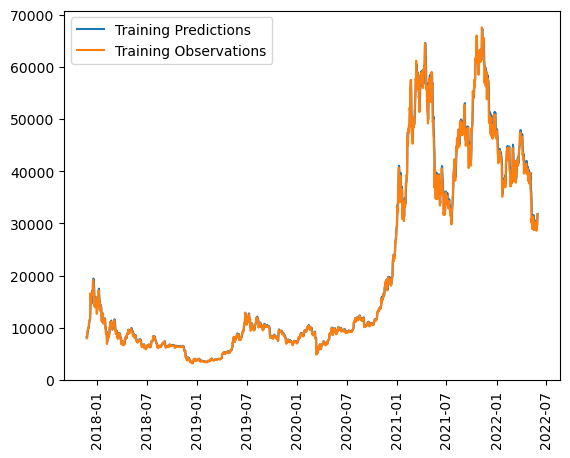

In [55]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [56]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.001360935508273542
Val MAE: 0.026330284774303436


8/8 [==============================] - 0s 4ms/step


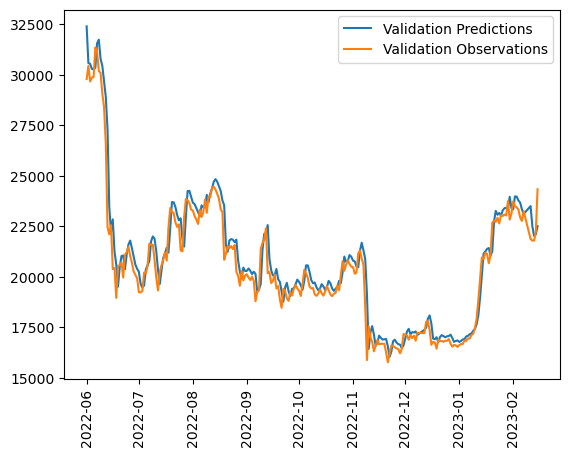

In [57]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [58]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0007294947281479836
Test MAE: 0.02133062109351158


7/7 [==============================] - 0s 4ms/step


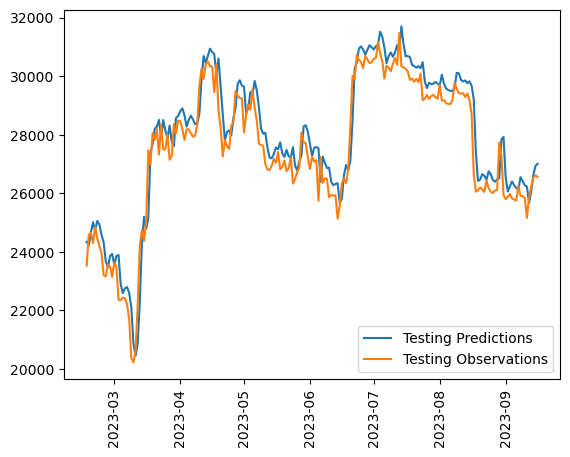

In [59]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [60]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9044736817907971


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [73]:


# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, lookback, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 28ms/step
[10.203734, 10.215409, 10.228706, 10.2417755, 10.254718, 10.267613, 10.280427]
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23


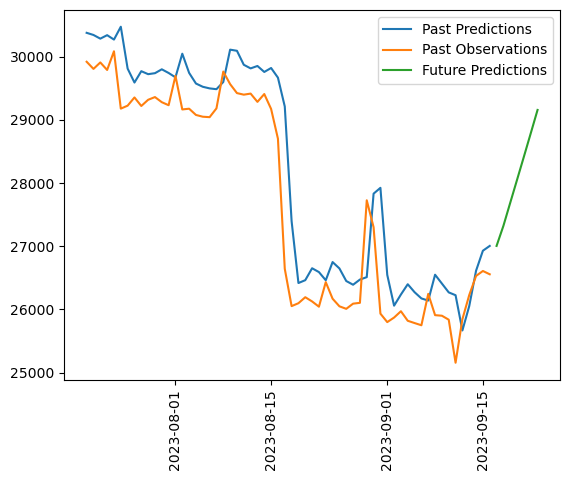

In [74]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [75]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day.h5")

In [76]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2, "observed":np.exp(y_test2), "predicted":np.exp(test_predictions3)})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,predicted,future_prediction
Date,,,
2023-02-16,23521.0,24339.699219,NaN
2023-02-17,24580.0,24215.181641,NaN
2023-02-18,24640.0,24661.201172,NaN
2023-02-19,24296.0,25005.691406,NaN
2023-02-20,24843.0,24728.814453,NaN


In [77]:
past_future_df.tail()

,observed,predicted,future_prediction
Date,,,
2023-09-19,NaN,NaN,27686.671875
2023-09-20,NaN,NaN,28050.884766
2023-09-21,NaN,NaN,28416.289062
2023-09-22,NaN,NaN,28785.105469
2023-09-23,NaN,NaN,29156.320312


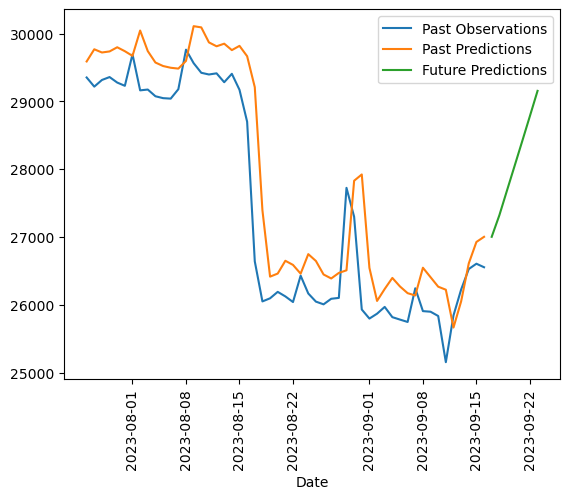

In [78]:
past_future_df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Past Observations', 'Past Predictions','Future Predictions'])
plt.show()

In [79]:
past_df = pd.read_csv('output/btc_predict.csv')

past_df = past_df[["predicted"]]

past_df = past_df.rename(columns={"predicted":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

,observed,predicted,future_prediction,past_pred
2023-02-16,23521.0,24339.699219,NaN,NaN
2023-02-17,24580.0,24215.181641,NaN,NaN
2023-02-18,24640.0,24661.201172,NaN,NaN
2023-02-19,24296.0,25005.691406,NaN,NaN
2023-02-20,24843.0,24728.814453,NaN,NaN


In [80]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [81]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [82]:
#output original historical data to csv
df_combined.to_csv('output/btc_predict_hist.csv')